In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
master_url_root="https://raw.githubusercontent.com/numenta/NAB/master/data/"
df_small_noise_url_suffix="artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url=master_url_root+df_small_noise_url_suffix
df_small_noise=pd.read_csv(df_small_noise_url,parse_dates=True,index_col="timestamp")

In [ ]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [ ]:
df_small_noise[150:200]

In [ ]:
df_daily_jumpsup_url_suffix="artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url=master_url_root+df_daily_jumpsup_url_suffix
df_daily_jumpsup=pd.read_csv(df_daily_jumpsup_url,parse_dates=True,index_col="timestamp")

In [ ]:
len(df_daily_jumpsup)

4032

In [ ]:
len(df_small_noise)

4032

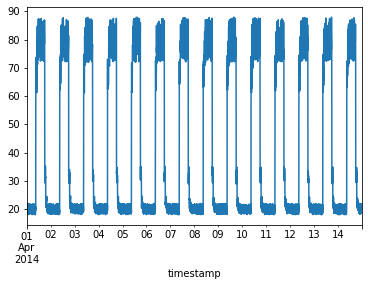

In [ ]:
fig,ax=plt.subplots()
df_small_noise.plot(legend=False,ax=ax)
plt.show()

In [ ]:
training_mean=df_small_noise.mean()
training_std=df_small_noise.std()
df_training_value=(df_small_noise-training_mean)/training_std

In [ ]:
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [ ]:
TIME_STEPS=288
def create_sequences(values,time_steps=TIME_STEPS):
  output=[]
  for i in range(len(values)-time_steps):
    output.append(values[i:(i+time_steps)])
  return np.stack(output)

In [ ]:
x_train=create_sequences(df_training_value.values)
print("Training input shape:",x_train.shape)

Training input shape: (3744, 288, 1)


In [ ]:
x_train[1]

In [ ]:
model=keras.Sequential([layers.Input(shape=(x_train.shape[1],x_train.shape[2])),
                        layers.Conv1D(filters=32,kernel_size=7,padding="same",strides=2,activation="relu"),
                        layers.Dropout(rate=0.2),
                        layers.Conv1D(filters=16,kernel_size=7,padding="same",strides=2,activation="relu"),
                        layers.Conv1DTranspose(filters=16,kernel_size=7,padding="same",strides=2,activation="relu"),
                        layers.Dropout(rate=0.2),
                        layers.Conv1DTranspose(filters=32,kernel_size=7,padding="same",strides=2,activation="relu"),
                        layers.Conv1DTranspose(filters=1,kernel_size=7,padding="same"),])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss="mse")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [ ]:
import tensorflow as tf

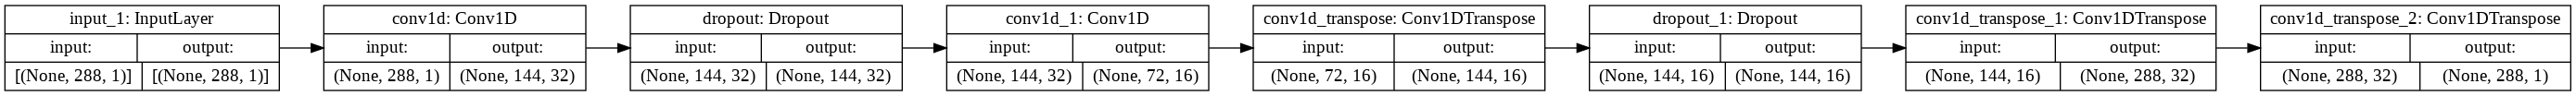

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [ ]:
history=model.fit(x_train,x_train,epochs=50,batch_size=128,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,mode="min")])

Epoch 1/50
27/27 [==============================] - 8s 17ms/step - loss: 0.7526 - val_loss: 0.1484
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: 0.1032 - val_loss: 0.0409
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0608 - val_loss: 0.0373
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0532 - val_loss: 0.0333
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0296
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0426 - val_loss: 0.0261
Epoch 7/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0382 - val_loss: 0.0238
Epoch 8/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0350 - val_loss: 0.0219
Epoch 9/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0323 - val_loss: 0.0209
Epoch 10/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0302 - val_loss: 0.0207
Epoch 11/50
27/27 

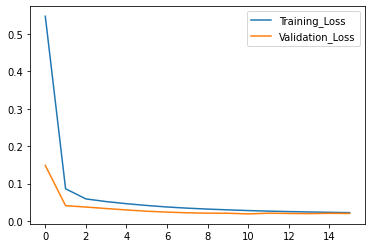

In [ ]:
plt.plot(history.history["loss"],label="Training_Loss")
plt.plot(history.history["val_loss"],label="Validation_Loss")
plt.legend()
plt.show()

In [ ]:
x_train_pred=model.predict(x_train)
train_mae_loss=np.mean(np.abs(x_train_pred-x_train),axis=1)


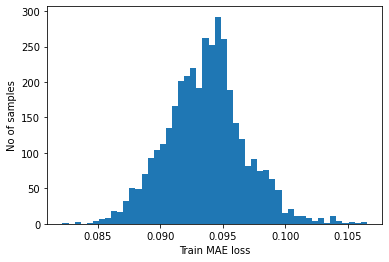

In [ ]:
plt.hist(train_mae_loss,bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
threshold=np.max(train_mae_loss)
print("Reconstruction error threshold:",threshold)

Reconstruction error threshold: 0.10650381649754409


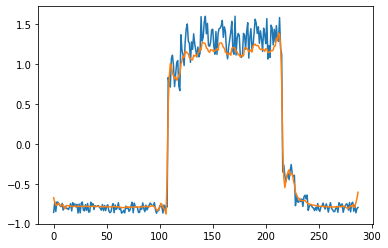

In [ ]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
def normalize_test(values,mean,std):
  values-=mean
  values/=std
  return values

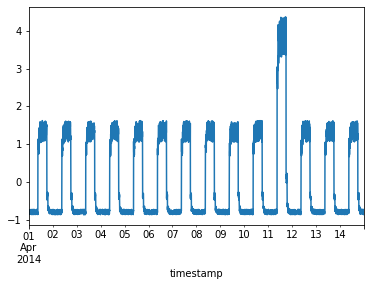

In [ ]:
df_test_value=(df_daily_jumpsup-training_mean)/training_std
fig,ax=plt.subplots()
df_test_value.plot(legend=False,ax=ax)
plt.show()

In [ ]:
df_daily_jumpsup[3000:3050]

,value
timestamp,
2014-04-11 10:00:00,138.118480
2014-04-11 10:05:00,159.259713
2014-04-11 10:10:00,147.399243
2014-04-11 10:15:00,150.046222
2014-04-11 10:20:00,150.082482
2014-04-11 10:25:00,154.798492
2014-04-11 10:30:00,130.600117
2014-04-11 10:35:00,136.698351
2014-04-11 10:40:00,149.593865


In [ ]:
x_test=create_sequences(df_test_value.values)

In [ ]:
print("Test input shape:",x_test.shape)

Test input shape: (3744, 288, 1)


In [ ]:
x_test_pred=model.predict(x_test)
test_mae_loss=np.mean(np.abs(x_test_pred-x_test),axis=1)
test_mae_loss=test_mae_loss.reshape((-1))

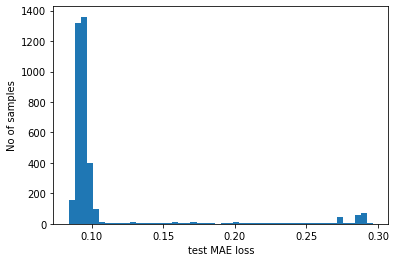

In [ ]:
plt.hist(test_mae_loss,bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
test_mae_loss

array([0.08910643, 0.09305795, 0.09209027, ..., 0.09492173, 0.09364147,
       0.09296566])

In [ ]:
anomalies=test_mae_loss>threshold
print("Number of anomaly samples",np.sum(anomalies))
print("Indices of anomaly samples",np.where(anomalies))

Number of anomaly samples 404
Indices of anomaly samples (array([1650, 1651, 1652, 1653, 1659, 2515, 2517, 2522, 2523, 2701, 2702,
       2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713,
       2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724,
       2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735,
       2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746,
       2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757,
       2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768,
       2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779,
       2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790,
       2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801,
       2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812,
       2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823,
       2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,

In [ ]:
len(anomalies)

3744

In [ ]:
np.all([[True,True],[True,True]])

True

In [ ]:
len(df_test_value)

4032

In [ ]:
TIME_STEPS

288

In [ ]:
len(df_test_value)-TIME_STEPS+1

3745

In [ ]:
anomalous_data_indices=[]
for data_idx in range(TIME_STEPS-1,len(df_test_value)-TIME_STEPS+1):
  if np.all(anomalies[data_idx-TIME_STEPS+1:data_idx]):
    anomalous_data_indices.append(data_idx)

In [ ]:
anomalous_data_indices

[2988,
 2989,
 2990,
 2991,
 2992,
 2993,
 2994,
 2995,
 2996,
 2997,
 2998,
 2999,
 3000,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014,
 3015,
 3016,
 3017,
 3018,
 3019,
 3020,
 3021,
 3022,
 3023,
 3024,
 3025,
 3026,
 3027,
 3028,
 3029,
 3030,
 3031,
 3032,
 3033,
 3034,
 3035,
 3036,
 3037,
 3038,
 3039,
 3040,
 3041,
 3042,
 3043,
 3044,
 3045,
 3046,
 3047,
 3048,
 3049,
 3050,
 3051,
 3052,
 3053,
 3054,
 3055,
 3056,
 3057,
 3058,
 3059,
 3060,
 3061,
 3062,
 3063,
 3064,
 3065,
 3066,
 3067,
 3068,
 3069,
 3070,
 3071,
 3072,
 3073,
 3074,
 3075,
 3076,
 3077,
 3078,
 3079,
 3080,
 3081,
 3082,
 3083,
 3084,
 3085,
 3086,
 3087,
 3088,
 3089,
 3090,
 3091,
 3092,
 3093,
 3094,
 3095,
 3096]

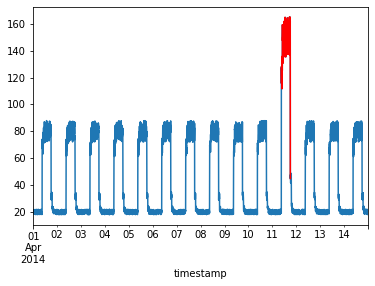

In [ ]:
df_subset=df_daily_jumpsup.iloc[anomalous_data_indices]
fig,ax=plt.subplots()
df_daily_jumpsup.plot(legend=False,ax=ax)
df_subset.plot(legend=False,ax=ax,color="r")
plt.show()